In [8]:
!pip install mne

In [12]:
# Импорт необходимых библиотек
import os  # Работа с файлами и путями
import numpy as np  # Работа с массивами чисел
import pandas as pd  # Работа с таблицами (как Excel)
import mne  # Основная библиотека для анализа ЭЭГ
from scipy.io import loadmat  # Загрузка данных в формате .mat (как в MATLAB)
from scipy.signal import welch  # Спектральный анализ сигнала
import matplotlib.pyplot as plt  # Для построения графиков

## Пример 2: Датасет по вызванным потенциалам

Данный датасет получен в эксперименте по набору текста P300 speller. В ходе эксперимента испытуемым показывают таблицу с символами, среди которых есть буквы, цифры и символ подчёркивания. Для набора одного из символов испытуемый сосредотачивается на нужном символе, наблюдая за тем, как последовательно в случайном порядке подсвечиваются различные строки и столбцы таблицы. Данные подсвечивания вызывают различную реакцию в мозге, в зависимости от того, подсветился ли необходимый символ. ИМК система настраивается таким образом, чтобы различать 2 реакции: на мишень (target) и не-мишень (non-target).

Для выбора конкретного символа необходимо подсветить каждую строку и каждый столбец хотя бы один раз. Те строка и столбец, которые снаибольшей вероятностью определяются, как мишень, однозначно задают искомый символ. Для повышения точности предсказания символа можно пройтись по всем строкам и столбцам несколько раз и усреднить результат.

In [13]:
folderP300 = 'BCI_Comp_III_Wads_2004'  # Указываем имя папки, в которой лежат данные для анализа P300


### Создание Raw объета из неподдерживаниемого формата

Многие лаборатории в област ИМК работают с ЭЭГ данными в MATLAB. Поэтому публичные датасеты иногда предоставляются в виде *.mat файлов в самых различных форматах. В данном примере мы создадим Raw объект из имеющихся данных.

Для начала загрузим сигнал. Несколько позиций в загружаемом словаре содержат 2D и 3D массивы, содержащие как сами данные, так и информацию о ходе эксперимента. Структура данных описана в Figure 3. Будьте внимательны, у нас будет перегружено слово эпоха (Epoch).

Эпоха как непрерывный период эксперимента, когда мишенью был конкретный символ. Такая эпоха содержит 180 подсветок строк и столбцов (по 15 раз).
Эпоха как вызванный потенциал, ассоциированный с одной подсветкой строки или столбца.
Для всех массивов первая размерность - это эпоха символа, а вторая - это время.

Для того, чтобы одним числом обозначить, в какой момент времени подсвечен мишень, а в какой не-мишень, мы складываем массивы Flashing и StimulusType и присоединяем результат к сигналу в качестве дополнительного канала.

Будем работать с данными испытуемого А.

In [ ]:
matP300 = loadmat(os.path.join(folderP300, 'Subject_A_Train.mat'))
# Загружаем .mat-файл, в котором находятся данные ЭЭГ.
# os.path.join(folderP300, 'Subject_A_Train.mat') — объединяет имя папки и имя файла.
# loadmat(...) — читает файл формата MATLAB (.mat) и возвращает его содержимое в виде словаря.
# В результате matP300 — это словарь, содержащий несколько таблиц: сигналы, стимулы, вспышки и т.д.

dataStim = matP300['Flashing'] + matP300['StimulusType']
# Извлекаем два массива: 'Flashing' и 'StimulusType'.
# 'Flashing' — информация о том, в какие моменты времени происходили вспышки на экране.
# 'StimulusType' — какой именно стимул показывался (например, целевой или нецелевой).
# Складывая их, мы получаем общую таблицу событий: когда и какой тип стимула был.

dataP300 = np.dstack((matP300['Signal'], dataStim))
# matP300['Signal'] — многомерный массив сигналов ЭЭГ.
# np.dstack(...) — объединяет массив сигналов и массив стимулов по третьему измерению (глубине).
# Это означает, что к каждому временному ряду сигналов добавляется информация о том, что происходило в этот момент.
# dataP300 теперь содержит сигналы и стимулы в едином формате: [испытания, время, каналы + стимул].


Создадим переменную info, содержащую базовую информацию о сигнале. Также немного отредактируем названия каналов из предоставленного файла.

In [ ]:
loc_df = pd.read_table(os.path.join(folderP300, 'eloc64.txt'), header=None, names=['id', 'angle', 'radius', 'name'])
# Загружаем файл 'eloc64.txt', в котором описаны координаты электродов ЭЭГ.
# os.path.join(...) — создаёт путь к файлу.
# pd.read_table(...) — читает текстовый файл как таблицу (разделённую пробелами или табуляцией).
# header=None — говорит, что в файле нет заголовков строк, поэтому мы задаём их вручную.
# names=... — указываем имена колонок:
# 'id' — номер канала,
# 'angle' — угловая координата,
# 'radius' — расстояние от центра головы,
# 'name' — имя канала (например, Fz, Cz, P3 и т.д.).

loc_df.name
# Из этой таблицы берём только колонку с названиями электродов (имена каналов).
# Это будет список типа: ['Fp1', 'Fp2', 'F3', 'F4', ..., 'Oz']


0     Fc5.
1     Fc3.
2     Fc1.
3     Fcz.
4     Fc2.
      ... 
59    Po8.
60    O1..
61    Oz..
62    O2..
63    Iz..
Name: name, Length: 64, dtype: object

In [ ]:
ch_names = loc_df.name.to_list() + ['STI 001']
# ch_names — список всех имён каналов.
# loc_df.name.to_list() — преобразует колонку 'name' из таблицы координат в обычный список.
# Добавляем ещё один канал 'STI 001' — это специальный канал, в котором записаны сигналы о событиях (например, стимулы на экране).

ch_types = ['eeg'] * (len(ch_names) - 1) + ['stim']
# Указываем тип для каждого канала:
# Все, кроме последнего ('STI 001'), — это 'eeg' (электроэнцефалограмма).
# Последний канал — 'stim', то есть событие (вспышка, стимул, нажатие кнопки и т.п.).

sampling_freq = 240
# Частота дискретизации — сколько раз в секунду измеряется сигнал на каждом канале.
# Здесь 240 Гц, то есть 240 измерений в секунду.

info = mne.create_info(ch_names, ch_types=ch_types, sfreq=sampling_freq)
# Создаём объект "info" — он содержит все метаданные о каналах:
# названия, типы, частоту измерения и позже — расположение электродов на голове.


def convert_ch_name(name):
  upper = name.upper().strip('.')
  return upper.replace('Z', 'z').replace('FP', 'Fp')
  #return name.lower().capitalize().strip('.')
  # Функция принимает строку (имя канала), приводит к верхнему регистру,
  # удаляет точки (если есть), затем:
  # заменяет 'Z' на 'z' (так нужно для стандарта MNE),
  # заменяет 'FP' на 'Fp' (тоже для корректной визуализации).



mne.rename_channels(info, convert_ch_name)
# Применяем функцию переименования ко всем каналам в объекте info.
# Это нужно для того, чтобы имена совпадали с названиями в стандартных схемах (montage).

info
# Показываем информацию обо всех каналах: сколько их, как называются, какие типы, с какой частотой пишутся.


<Info | 7 non-empty values
 bads: []
 ch_names: FC5, FC3, FC1, FCz, FC2, FC4, FC6, C5, C3, C1, Cz, C2, C4, C6, ...
 chs: 64 EEG, 1 Stimulus
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 120.0 Hz
 meas_date: unspecified
 nchan: 65
 projs: []
 sfreq: 240.0 Hz
>

Для возможности создания топографических карт подгружаем стандартную схему расположения электродов.

In [ ]:
# Создаём стандартную схему расположения электродов на голове (монтаж) под названием 'standard_1020'.
# Эта схема называется 10-20 и является общепринятым расположением электродов в ЭЭГ.
# Она определяет, где на голове должны быть размещены электроды, например: Fp1, Fp2, Fz, Cz, Pz и т.д.
# Эта информация используется далее, чтобы правильно визуализировать и интерпретировать данные ЭЭГ.
montageP300 = mne.channels.make_standard_montage('standard_1020')

Наконец, создаём сам объект класса Raw, содержащий все тренировочные данные. Данные обрабатываются по одной эпохе символа, затем объединяются. Так будет удобнее изучить данные.

In [ ]:
# Создаём пустой список, в который будем добавлять "сырые" ЭЭГ-сигналы каждого прогона (испытания)
rawEEGP300 = []

# Цикл по каждому прогону (trial) в массиве dataP300
# dataP300.shape[0] — это количество прогонов (испытаний) в эксперименте
for trial in range(dataP300.shape[0]):
  # В каждой итерации:
  # - Берём данные для одного прогона: dataP300[trial,...]
  # - Транспонируем их (меняем местами оси), чтобы привести к нужному формату: (каналы, временные точки)
  # - Создаём объект RawArray, представляющий ЭЭГ как непрерывный поток данных
  # - Используем структуру info, которая описывает каналы
  # - verbose=False отключает лишние сообщения при создании объекта
  rawEEGP300.append(mne.io.RawArray(dataP300[trial,...].T, info, verbose=False))

# Объединяем все отдельные прогоны в один непрерывный сигнал
# Эта функция соединяет все RawArray в один большой объект
mne.concatenate_raws(rawEEGP300)

# Из списка rawEEGP300 берём первый (и теперь уже объединённый) объект и сохраняем обратно в ту же переменную
rawEEGP300 = rawEEGP300[0]

# Применяем схему размещения электродов (монтаж), чтобы MNE знал, где на голове находится каждый электрод
rawEEGP300.set_montage(montageP300)


<RawArray | 65 x 662490 (2760.4 s), ~328.6 MB, data loaded>

### Визуализация данных

Временной ряд по всем каналам можно изобразить методом plot().

Using matplotlib as 2D backend.


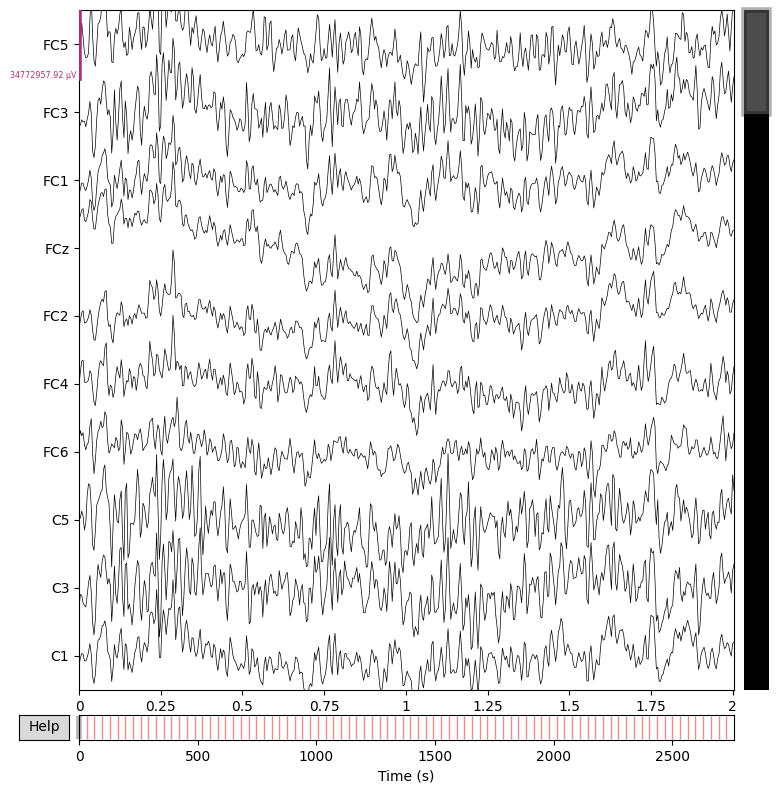

In [ ]:
# Отображаем график ЭЭГ-сигналов с помощью встроенной функции визуализации MNE
# Эта функция рисует временные ряды (волны) с разных электродов (каналов)

rawEEGP300.plot(
    start=0,           # Время начала отображения в секундах (0 = с самого начала записи)
    duration=2,        # Длительность отображаемого фрагмента в секундах (здесь показывается 2 секунды сигнала)
    n_channels=10,     # Количество каналов (электродов), которые будут отображены одновременно (здесь 10)
    scalings='auto'    # Масштаб автоматически подбирается MNE под амплитуду каждого канала
);



Для данного датасета интереснее взглянуть на распространение вызванных потенциалов.

Находим события для мишеней и немишеней. Всего больше 15 тысяч таких событий.

15300 events found
Event IDs: [1 2]


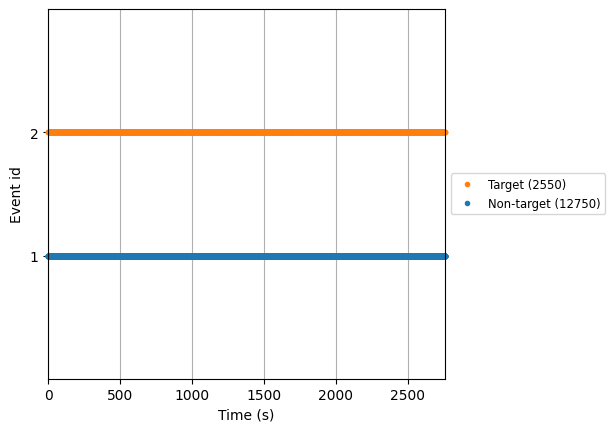

In [ ]:
# Создаём словарь с описанием событий: тип события и соответствующее числовое значение
# Эти значения соответствуют меткам стимулов, заданным в исходных данных
event_id = {
    'Non-target': 1,   # Нецелевой стимул (например, обычное мигание)
    'Target': 2        # Целевой стимул (например, важное мигание, на которое нужно реагировать)
}

# Извлекаем события (стимулы) из "сырых" ЭЭГ-данных
# rawEEGP300 — это наш объединённый сигнал
# stim_channel='STI 001' — канал, в котором записаны коды стимулов
# initial_event=True — включает первое событие, даже если оно было в начале записи
events = mne.find_events(
    rawEEGP300,
    stim_channel='STI 001',
    initial_event=True
)

# Визуализируем найденные события на временной шкале
# sfreq — частота дискретизации, нужна для перевода точек в секунды
# first_samp — первая временная отметка (важна, если данные начинались не с нуля)
# event_id — указывает, какие события каким меткам соответствуют
fig = mne.viz.plot_events(
    events,
    sfreq=rawEEGP300.info['sfreq'],
    first_samp=rawEEGP300.first_samp,
    event_id=event_id
)

# Регулируем положение легенды графика, сдвигая границу справа
fig.subplots_adjust(right=0.7)  # Оставляем место для легенды справа от графика


Применим уже известный CAR для удаления пространственного шума.

In [ ]:
# Устанавливаем ссылочный (референтный) электрод для всех ЭЭГ-каналов
# В ЭЭГ каждый канал измеряет разность потенциалов между электродом и референтной точкой
# Этот шаг важен для корректного анализа, так как влияет на форму сигнала

mne.set_eeg_reference(
    rawEEGP300,              # Объект с ЭЭГ-данными, к которым применяем переотнесение
    ref_channels='average',  # Используем среднее значение по всем ЭЭГ-каналам как опорную точку (average reference)
    projection=False         # False означает, что переотнесение будет выполнено сразу, а не отложено до дальнейшего этапа (например, при визуализации)
)


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


(<RawArray | 65 x 662490 (2760.4 s), ~328.6 MB, data loaded>,
 array([ -4.66049573,  -2.16184328,   1.15784927, ..., -15.35142082,
        -12.33463581, -13.33911076]))

Экстракция эпох.

In [ ]:
# Разбиваем непрерывный ЭЭГ-сигнал на отдельные фрагменты (эпохи), связанные с событиями (например, миганиями)
# Эти фрагменты называются эпохами (epochs) и используются для усреднения и анализа мозговых реакций

epochsP300 = mne.Epochs(
    rawEEGP300,          # Объект с сырым ЭЭГ-сигналом, из которого выделяются эпохи
    events,              # Массив событий (stimulus onset), определённых ранее через mne.find_events
    event_id=event_id,   # Словарь с метками событий (например, 1 — Non-target, 2 — Target)
    tmin=-0.5,           # Время начала эпохи относительно события: за 0.5 секунды ДО события
    tmax=1.0,            # Время конца эпохи: 1.0 секунда ПОСЛЕ события
    baseline=(-0.5, 0)   # Указываем базовый интервал: от -0.5 до 0 секунд (до события) — для вычитания фоновой активности
)


Not setting metadata
15300 matching events found
Applying baseline correction (mode: mean)
0 projection items activated



Усредняя все эпохи отдельно для каждого типа событий (мишень и не-мишень), мы можем чётче увидеть вызванные потенциалы.

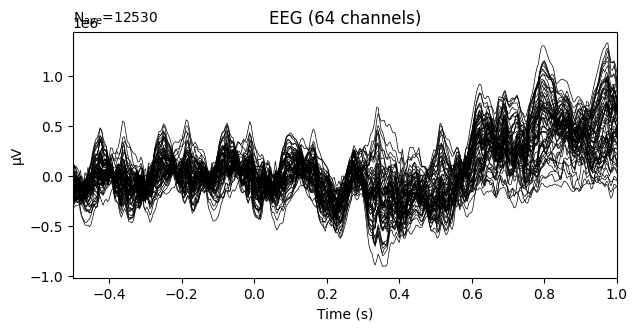

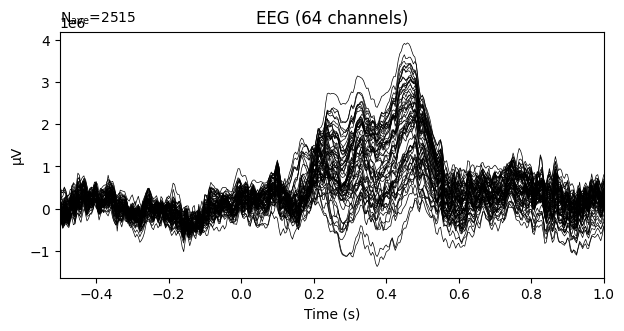

In [ ]:
# Усредняем эпохи по каждому типу события (целевой и нецелевой стимул)
# Это позволяет выделить стабильные особенности ответа мозга на каждый вид стимула (например, компонент P300)
# by_event_type=True означает, что усреднение происходит отдельно для каждого значения в event_id

evokedP300_list = epochsP300.average(by_event_type=True)

# Строим график усреднённого сигнала (первый тип события, например, 'Non-target')
# Показывает характерный ответ мозга на нецелевой стимул
evokedP300_list[0].plot();

# Строим график усреднённого сигнала (второй тип события, например, 'Target')
# Это главный интерес — здесь должен проявиться компонент P300 (пик примерно на 300 мс)
evokedP300_list[1].plot();


Вызванные потенциалы, как правило, сосредоточенны в более низком диапазоне частот. Поэтому может быть полезно отфильтровать высокочастотные шумы.

In [ ]:
# Создаём копию исходного ЭЭГ-сигнала, чтобы не изменить оригинал
filteredEEGP300 = rawEEGP300.copy()

# Применяем полосовой фильтр к ЭЭГ-данным
# l_freq=0.5 — нижняя граница фильтра: отсекаем медленные колебания ниже 0.5 Гц
# h_freq=15 — верхняя граница фильтра: отсекаем быстрые колебания выше 15 Гц
# Это помогает убрать шумы и выделить важные частоты (например, компонент P300 находится в этом диапазоне)
filteredEEGP300 = filteredEEGP300.filter(l_freq=0.5, h_freq=15)

# Меняем частоту дискретизации (переход на более низкое разрешение по времени)
# sfreq = 120 означает, что теперь каждый канал будет записываться 120 раз в секунду
# Это может ускорить вычисления и уменьшить объём данных
sfreq = 120
filteredEEGP300.resample(sfreq)

# Повторно ищем события после фильтрации и ресемплинга
# stim_channel — канал стимулов (ранее использовался 'STI 001')
events = mne.find_events(filteredEEGP300, stim_channel='STI 001', initial_event=True)

# Формируем новые эпохи на основе отфильтрованного сигнала
# Параметры такие же, как и раньше:
# - tmin=-0.5: полсекунды до события
# - tmax=1: одна секунда после события
# - baseline=(-0.5, 0): выравниваем по фоновому уровню до события
filteredEpochsP300 = mne.Epochs(
    filteredEEGP300,
    events,
    event_id=event_id,
    tmin=-0.5,
    tmax=1,
    baseline=(-0.5, 0)
)

# Усредняем отфильтрованные эпохи по каждому типу события
# Получаем два усреднённых ответа: один для целевого, один для нецелевого стимула
filteredEvokedP300_list = filteredEpochsP300.average(by_event_type=True)

#filteredEpochsP300.plot(n_epochs=10);

Filtering raw data in 85 contiguous segments
Setting up band-pass filter from 0.5 - 15 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 15.00 Hz
- Upper transition bandwidth: 3.75 Hz (-6 dB cutoff frequency: 16.88 Hz)
- Filter length: 1585 samples (6.604 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished


Trigger channel has a non-zero initial value of 1 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
15299 events found
Event IDs: [1 2]
Trigger channel has a non-zero initial value of 1 (consider using initial_event=True to detect this event)
Removing orphaned offset at the beginning of the file.
15299 events found
Event IDs: [1 2]
15300 events found
Event IDs: [1 2]
Not setting metadata
15300 matching events found
Applying baseline correction (mode: mean)
0 projection items activated


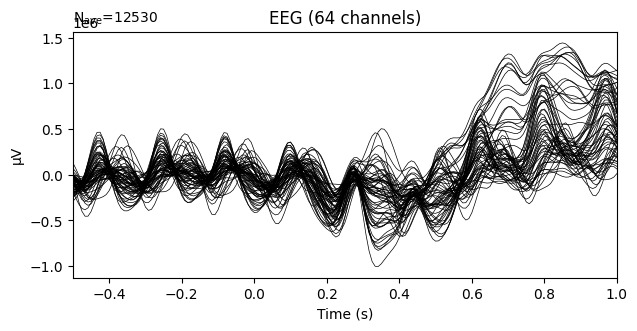

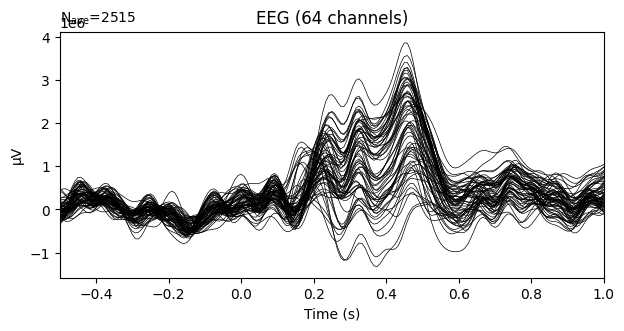

In [ ]:
# Отображаем усреднённый ЭЭГ-ответ на первый тип события (обычно Non-target)
# Это график средневзвешенной активности мозга, полученной из множества отдельных эпох
filteredEvokedP300_list[0].plot();

# Отображаем усреднённый ЭЭГ-ответ на второй тип события (обычно Target)
# Здесь, как правило, и появляется компонент P300 — положительный пик около 300 мс после стимула
filteredEvokedP300_list[1].plot();



Полезный метод plot_joint() может показать временной ряд для вызванного потенциала вместе с топографическими картами для выбранных моментов времени.

No projector specified for this dataset. Please consider the method self.add_proj.


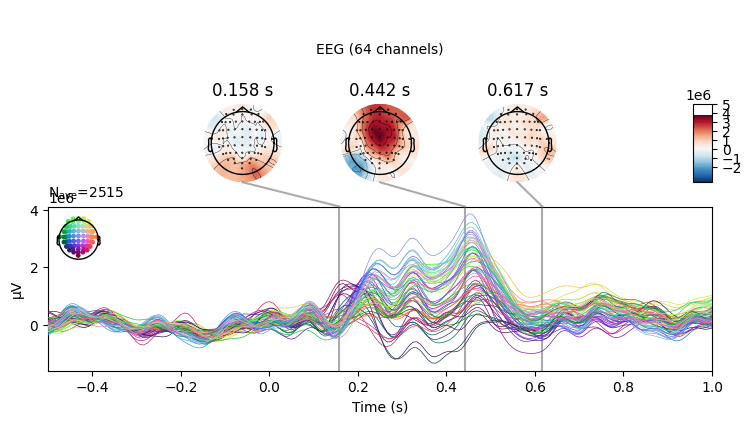

In [ ]:
# Выбираем только эпохи, относящиеся к целевым стимулам ('Target')
# Затем усредняем их, чтобы получить типичный (средний) ответ мозга на целевой стимул
# После этого строим комбинированный график (plot_joint), который включает:
# 1) временной график (сигналы с электродов)
# 2) топографию распределения активности на голове (в определённый момент)
filteredEpochsP300['Target'].average().plot_joint();

Другая полезная функция plot_compare_evokeds позволяет стравнить вызванные потенциалы для различных событий. Исходя из предыдущего графика, интересным каналом выглядит Cz в центре скальпа.

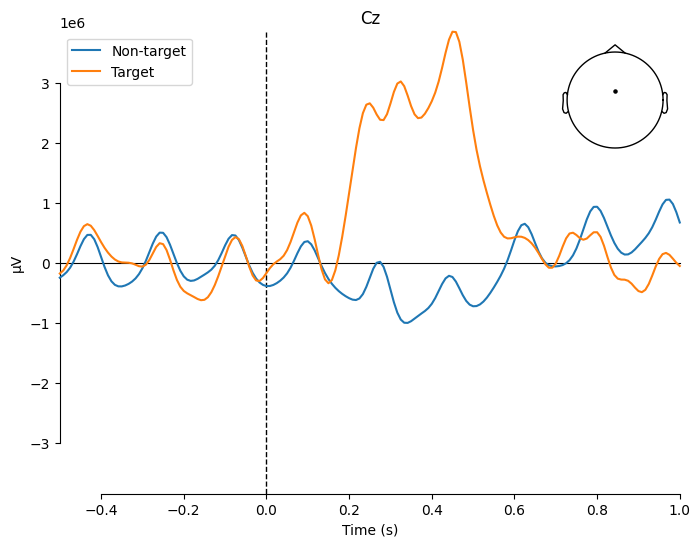

In [ ]:
# Сравниваем усреднённые ЭЭГ-ответы на разные типы стимулов (Target и Non-target)
# Функция строит графики двух (или более) усреднённых сигналов на одном рисунке для сравнения

mne.viz.plot_compare_evokeds(
    filteredEvokedP300_list,  # Список усреднённых ответов (Evoked) — один на каждый тип события
    picks='Cz'                # Отображаем данные только с одного канала — Cz (центральный электрод на макушке)
                             # На канале Cz компонент P300 чаще всего наиболее выражен
)


Мы также можем линейно скомбинировать вызванные потенциалы. В данном случае мы вычитаем вызванный потенциал не-мишеней из вызванных потенциалов мишеней (Target - Non-Target).

Далее можно посмотреть на эволюцию этой разницы по всему скальпу, построив топографические карты для отдельных моментов времени.

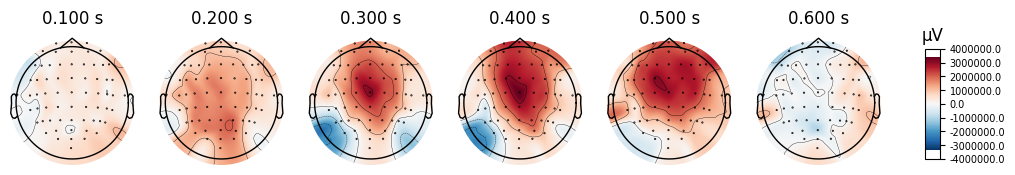

In [ ]:
# Вычисляем разницу между двумя усреднёнными сигналами: Target минус Non-target
# Это позволяет выделить только ту мозговую активность, которая специфична для реакции на целевой стимул (например, компонент P300)

evoked_diff = mne.combine_evoked(
    filteredEvokedP300_list,  # Список усреднённых ответов [Non-target, Target]
    [-1, 1]                   # Веса для вычитания: -1 * Non-target + 1 * Target = Target - Non-target
)

# Добавляем поясняющий комментарий к полученному объекту: например "Target - Non-target"
evoked_diff.comment = '{} - {}'.format(
    filteredEvokedP300_list[1].comment,  # Имя второго условия (Target)
    filteredEvokedP300_list[0].comment   # Имя первого условия (Non-target)
)

# Указываем моменты времени, в которые хотим построить топографические карты (в секундах после стимула)
# Здесь это: 0.1 с, 0.2 с, ..., до 0.6 с
times = np.arange(0.1, 0.7, 0.1)

# Строим топографические карты (распределение напряжений на голове) в заданные моменты времени
# colorbar=True — отображать цветовую шкалу, показывающую амплитуду сигнала
evoked_diff.plot_topomap(
    times=times,
    colorbar=True
)


## Пример 2: классификация эпох и набор текста

### Подготовка данных

В отличие от предыдущего раздела, нам необходимо спектрально фильтровать эпохи символов отдельно друг от друга. Кроме того, первая подсветка таблицы начинается с нулевого момента времени. Поэтому tmin для экстракции эпох не может быть меньше 0. По той же причине бэйзлайн тоже устанавливаем в 0.

Метод get_data позволяет получить обычный массив данных из объекта эпох.

In [ ]:
# Создаём пустой список для хранения всех эпох (epochs) по всем прогонам
epochs_list = []

# Определяем события (типы стимулов) и присваиваем им числовые коды
event_id = {'Non-target': 1, 'Target': 2}

# Список для хранения индексов групп (прогонов)
groups = []

# Новая частота дискретизации после ресемплинга
sfreq = 60  # 60 Гц — то есть 60 измерений в секунду

# Проходим по каждому прогону (экспериментальному повторению) в исходном наборе
for trial in range(dataP300.shape[0]):

  # Преобразуем сигнал прогона в формат MNE RawArray
  rawEEGP300 = mne.io.RawArray(dataP300[trial,...].T, info, verbose=False)

  # Применяем стандартное расположение электродов (монтаж 10-20)
  rawEEGP300.set_montage(montageP300, verbose=False)

  # Переотнос к среднему значению по всем каналам (average reference)
  mne.set_eeg_reference(
      rawEEGP300,
      ref_channels='average',
      projection=False,
      verbose=False
  )

  # Применяем полосовой фильтр (оставляем сигналы от 0.5 до 15 Гц)
  filteredEEGP300 = rawEEGP300.filter(l_freq=0.5, h_freq=15, verbose=False)

  # Уменьшаем частоту дискретизации до 60 Гц, чтобы ускорить обработку
  filteredEEGP300.resample(sfreq, verbose=False)

  # Ищем события (стимулы) в канале 'STI 001'
  events = mne.find_events(
      filteredEEGP300,
      stim_channel='STI 001',
      initial_event=True,
      verbose=False
  )

  # Выделяем эпохи (отрезки ЭЭГ вокруг событий):
  # - от 0 до 1 секунды после появления стимула
  # - baseline=(0, 0) — не выполняется вычитание фоновой активности
  filteredEpochsP300 = mne.Epochs(
      filteredEEGP300,
      events,
      event_id=event_id,
      tmin=0,
      tmax=1,
      baseline=(0, 0),
      verbose=False
  )

  # Сохраняем полученные эпохи в общий список
  epochs_list.append(filteredEpochsP300)

  # Сохраняем, какой прогон (trial) принадлежит каждой эпохе — нужен для группового анализа
  groups.append(np.ones(len(events)) * trial)

# Объединяем все эпохи из разных прогонов в один большой объект
epochsP300 = mne.concatenate_epochs(epochs_list, verbose=False)

# Объединяем список индексов прогонов в один массив (одна метка на каждую эпоху)
groups = np.concatenate(groups)

# Извлекаем данные ЭЭГ для каждой эпохи в интервале от 0.1 до 0.8 секунды после стимула
# Получается массив формы (n_epochs, n_channels, n_times)
P300_data = epochsP300.get_data(tmin=0.1, tmax=0.8)


### Классификация отдельных эпох

Для классификации векторизую данные и применим стандартный линейный бинарный классификатор LDA. Как и в предыдущем примере применим кросс-валидацию для оценки качества. Но в данном примере нам нельзя допустить попадания эпох из одного и той же эпохи символа в тренировочный и валидационные датасеты. Поэтому в предыдущей ячейке мы создали переменную groups, которая будет использоваться кросс-валидационным методов GroupKFold.

Качесто бинарной классификации с несбалансированными классами часто оценивают с помощью метрики ROC AUC (площадь под ROC кривой).

In [ ]:
# Импортируем необходимые компоненты из библиотеки scikit-learn:
from sklearn.pipeline import make_pipeline                       # Для создания пошагового конвейера (pipeline)
from sklearn.model_selection import cross_val_score, cross_val_predict, GroupKFold  # Для кросс-валидации с учётом групп
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis  # Классификатор LDA
from sklearn.metrics import roc_auc_score, make_scorer           # Метрика качества — площадь под ROC-кривой (AUC)

# Создаём классификационный конвейер:
# 1. Vectorizer — превращает данные из формата (n_epochs, n_channels, n_times) в векторную форму для scikit-learn
# 2. LinearDiscriminantAnalysis — простой и быстрый линейный классификатор
clf = make_pipeline(
    mne.decoding.Vectorizer(),
    LinearDiscriminantAnalysis()
)

# Создаём метрику ROC AUC в виде scorer-функции
# needs_proba=True — означает, что классификатор должен возвращать вероятности, а не метки классов
roc_auc_scorer = make_scorer(
    roc_auc_score,
    needs_proba=True
)

# Проводим перекрёстную проверку (cross-validation):
# - clf — наш классификатор
# - P300_data — данные: массив эпох (n_epochs, n_features)
# - epochsP300.events[:, 2] — метки классов: 1 (Non-target) или 2 (Target)
# - groups — список прогонов, чтобы не мешать данные из одного прогона в разных частях
# - cv=GroupKFold(n_splits=5) — делим на 5 фолдов по прогону (группе)
# - scoring=roc_auc_scorer — метрика качества: ROC AUC
score = cross_val_score(
    clf,
    P300_data,
    epochsP300.events[:, 2],     # Целевые метки классов
    groups=groups,               # Прогоны (используются как группы для кросс-валидации)
    cv=GroupKFold(n_splits=5),   # 5-кратная перекрёстная проверка с учётом групп
    scoring=roc_auc_scorer       # Оцениваем по метрике ROC AUC
)

# Выводим среднее значение ROC AUC и стандартное отклонение по всем фолдам
print('Mean ROC AUC: {} +/- {}'.format(score.mean(), score.std()))


Mean ROC AUC: 0.904512495194156 +/- 0.011281126014936254


### Точность набора текста

Результат в районе 0.9 - это доволно высокое качество классификации в данной задаче. Однако, не стоит забывать, что конечной целью является набор текста. Давайте оценим точность определения символа, задумыванного испытуемым.

Для удобства воспроизведём таблицу с символами в виде матрицы.

In [ ]:
char_layout = np.array([chr(c) for c in range(ord('A'), ord('Z')+1)] + list(map(str, range(1,10))) + ['_']).reshape(6,6)
char_layout

array([['A', 'B', 'C', 'D', 'E', 'F'],
       ['G', 'H', 'I', 'J', 'K', 'L'],
       ['M', 'N', 'O', 'P', 'Q', 'R'],
       ['S', 'T', 'U', 'V', 'W', 'X'],
       ['Y', 'Z', '1', '2', '3', '4'],
       ['5', '6', '7', '8', '9', '_']], dtype='<U1')

Тренируем классификатор на первых Etrain эпохах символа.

In [ ]:
# Задаём количество тренировочных эпох (символов), которые будут использоваться для обучения модели
Etrain = 65
# Например, пользователь "вводит" 65 разных символов глазами в ходе эксперимента — это и есть тренировочные эпохи

# Задаём общее число подсвечиваний за одну эпоху:
# В P300-спеллерах таблица 6x6 содержит 12 групп (6 строк + 6 столбцов)
# Каждая из этих 12 групп подсвечивается 15 раз, чтобы усилить сигнал и отследить реакцию
Ntrain = 15 * 12
# Получается 180 подсвечиваний на каждый символ (эпоху)

# Количество повторных подсвечиваний всей таблицы при попытке угадать символ во время предсказания
Nrepetition = 5
# То есть вся таблица (12 групп) будет подсвечена 5 раз → для усиления сигнала и улучшения точности

# Общее число подсвечиваний при предсказании одного символа:
Npred = Nrepetition * 12
# Это 60 вспышек (5 повторов × 12 строк/столбцов)


In [ ]:
# Обучаем классификатор на первых Etrain * Ntrain эпохах (для тренировки)
# P300_data — массив эпох формы (n_epochs, n_channels * n_times)
# epochsP300.events[:,2] — метки классов для каждой эпохи: 1 = Non-target, 2 = Target

clf.fit(
    P300_data[:Etrain * Ntrain],        # Обучающие данные: первые 65 * 180 = 11 700 эпох
    epochsP300.events[:Etrain * Ntrain, 2]  # Метки классов к этим эпохам (1 или 2)
)

# Предсказываем вероятности для оставшихся эпох (не входящих в тренировку)
# Это эпохи, относящиеся к стадии предсказания символа
# predict_proba возвращает вероятности для всех классов (Non-target и Target)
# [:, 1] — извлекаем вероятность именно для класса Target (второй столбец, так как 1 = Non-target, 2 = Target)
target_proba = clf.predict_proba(
    P300_data[Etrain * Ntrain:]
)[:, 1]  # Вероятность того, что данная эпоха принадлежит к классу Target


После этого оцениваем вероятность наличия мишени в каждом подсвечивании и выбираем наиболее вероятный символ в каждой эпохе символа.

In [ ]:
pred = []  # Список, в который будем сохранять предсказанные символы

# Цикл по каждой эпохе предсказания (всего 85 символов минус 65 обучающих = 20)
for t in range(85 - Etrain):

  # Получаем список кодов подсветок (StimulusCode) для соответствующей эпохи (символа)
  # Etrain + t — это номер текущей эпохи предсказания (начинается с 65-й)
  codes = matP300['StimulusCode'][Etrain + t]

  # Ищем моменты начала каждой подсветки:
  # np.diff(codes) > 0 — находит переходы от 0 к 1 (начало вспышки)
  # Добавляем 0 в начало, чтобы включить самую первую вспышку
  codes = codes[np.concatenate([np.array([0]), np.where(np.diff(codes) > 0)[0] + 1])]

  # Оставляем только первые Npred кодов (например, 60 — 5 повторов по 12 групп)
  codes = codes[:Npred]

  # Получаем соответствующие вероятности принадлежности к Target для этих вспышек
  single_proba = target_proba[t * Ntrain : t * Ntrain + Npred]

  # Считаем среднюю вероятность Target-класса для каждой из 12 строк и столбцов
  mean_proba = {}
  for code in range(1, 13):  # коды от 1 до 12
    mean_proba[code] = single_proba[np.where(codes == code)[0]].mean()

  # Выбираем тот столбец (code < 7), для которого средняя вероятность максимальна
  max_col = max(
    filter(lambda x: x[0] < 7, mean_proba.items()),
    key=lambda x: x[1]
  )[0]

  # Выбираем ту строку (code > 6), для которой средняя вероятность максимальна
  max_row = max(
    filter(lambda x: x[0] > 6, mean_proba.items()),
    key=lambda x: x[1]
  )[0]

  # Индексация в char_layout:
  # строки — от 7 до 12 → превращаем в 0–5 → max_row - 7
  # столбцы — от 1 до 6 → превращаем в 0–5 → max_col - 1
  char_pred = char_layout[max_row - 7, max_col - 1]

  # Добавляем угаданный символ в список предсказаний
  pred.append(char_pred)


Осталось подсчитать точность предсказания.

In [ ]:
# Импортируем функцию для оценки точности классификации
from sklearn.metrics import accuracy_score

# Извлекаем список "правильных" символов, которые нужно было угадать
# matP300['TargetChar'][0][65:] — символы с 65-й позиции до конца (после обучающих символов)
true = list(matP300['TargetChar'][0][65:])

# Выводим точность: сколько предсказаний совпали с правильными символами
# accuracy_score сравнивает списки: true (истинные символы) и pred (предсказанные)
print('Accuracy {}'.format(accuracy_score(true, pred)))

# Создаём таблицу: строка = [истинный символ, предсказанный символ, совпадение (True/False)]
# np.stack объединяет три списка в один массив
# .T транспонирует, чтобы каждая строка была одной попыткой
np.stack([
    true,                      # Истинные символы
    pred,                      # Предсказанные символы
    [t == p for t, p in zip(true, pred)]  # Список совпадений (True/False)
]).T


Accuracy 0.85


array([['L', 'L', 'True'],
       ['B', 'B', 'True'],
       ['W', 'W', 'True'],
       ['X', 'X', 'True'],
       ['E', 'E', 'True'],
       ['P', 'J', 'False'],
       ['O', 'O', 'True'],
       ['U', 'U', 'True'],
       ['I', 'I', 'True'],
       ['K', 'H', 'False'],
       ['Z', 'Z', 'True'],
       ['E', 'E', 'True'],
       ['R', 'R', 'True'],
       ['Y', 'Y', 'True'],
       ['O', 'O', 'True'],
       ['O', 'O', 'True'],
       ['T', 'T', 'True'],
       ['H', 'H', 'True'],
       ['Q', 'Q', 'True'],
       ['I', 'K', 'False']], dtype='<U5')